In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

In [5]:
import requests 
import json 

In [6]:
import scipy
from scipy.stats import ttest_ind

# Part 1 - Prepare SQLAlchemy 

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy import create_engine

In [8]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [9]:
# Preview the data model in Db Browser or a similar tool
# (do this to get a sense as to how the database is structured)
df_sm = pd.read_sql('SELECT * FROM station_measurements ORDER BY date', engine)
df_sm.head()

,station,name,latitude,longitude,elevation,date,day,month,prcp,temp
0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,2010-01-01,01,01,0.08,65.0
1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2010-01-01,01,01,0.28,67.0
2,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6,2010-01-01,01,01,0.21,72.0
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,2010-01-01,01,01,0.15,75.0
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2010-01-01,01,01,0.15,70.0


# Part 2 - Exploratory Climate Analysis

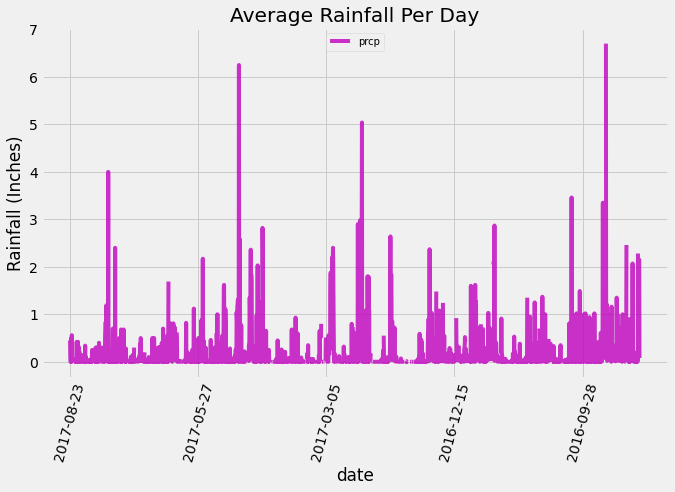

In [9]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
df_percip = pd.read_sql("""SELECT date, prcp
FROM station_measurements
WHERE date > 
    (SELECT  DATE(MAX(date), '-1 year') 
    FROM Measurement) ;
""", engine)
df_percip.set_index('date', inplace=True)
df_percip.head()

# Sort the dataframe by date
df_percip.sort_values(by='date', ascending=False, inplace=True)
df_percip.head()

# Use Pandas Plotting with Matplotlib to plot the data
plt.style.use('fivethirtyeight')
df_percip.plot(title="Average Rainfall Per Day", color='m', alpha=0.8, figsize=(10,6))
plt.xticks(rotation=75)
plt.legend(loc='upper center', prop={'size': 10})
plt.ylabel("Rainfall (Inches)")
plt.show()

In [10]:
# Use Pandas to calculate the summary statistics for the precipitation data
df_pd = df_sm
df_pd.describe()['prcp']

count    18103.000000
mean         0.160644
std          0.468746
min          0.000000
25%          0.000000
50%          0.010000
75%          0.110000
max         11.530000
Name: prcp, dtype: float64

In [11]:
# Design a query to show how many stations are available in this dataset?
df_station_count = pd.read_sql("""SELECT count(DISTINCT station) as station_count
FROM station_measurements;""", engine)
df_station_count.head()

,station_count
0,9


In [12]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
df_sm['station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: station, dtype: int64

In [12]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#USING PANDAS
moast_active = df_sm['station'].value_counts().index[0]
moast_active
#get station data 
df = df_sm.loc[df_sm['station'] == moast_active]
df
#lowest temp
df['temp'].min()
#highest temp
df['temp'].max()
#avg temp
df['temp'].mean()

#USING SQL
df_mas_data = pd.read_sql("""

SELECT min(temp), max(temp), avg(temp)
FROM station_measurements
WHERE station = 
  (SELECT station FROM(
    SELECT count(station)as cnt, station
    FROM measurement
    GROUP BY station
    ORDER BY count(station) DESC LIMIT 1
  ));

""", engine)
df_mas_data

,min(temp),max(temp),avg(temp)
0,54.0,85.0,71.663781


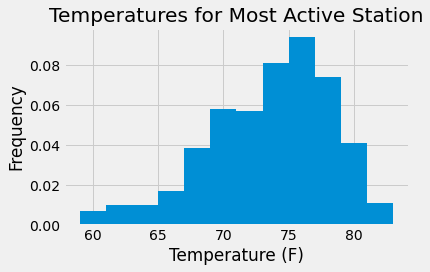

In [13]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df_temp_obvs = pd.read_sql("""

SELECT *
FROM station_measurements
WHERE station = 
  (SELECT station FROM(
    SELECT count(station)as cnt, station
    FROM measurement
    GROUP BY station
    ORDER BY count(station) DESC LIMIT 1
  )
 )
 AND date > 
    (SELECT  DATE(MAX(date), '-1 year') 
    FROM Measurement) ;

""", engine)
df_temp_obvs.head()
plt.style.use('fivethirtyeight')
df_temp_obvs['temp'].plot(kind='hist', title="Temperatures for Most Active Station", density=True, bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature (F)")
plt.tight_layout()
plt.show()

#oraganize df for percipitation end point
sql = """
        SELECT date, prcp FROM Measurement limit 10 
        """ 
    #exicutes a sql query
results = pd.read_sql(sql, engine)

results.set_index('date', inplace=True)
df = results.transpose()

lst = [ ]
for i, result in results.iterrows():
    dic = { }
    dic[result['date']] = result['prcp']
    lst.append(dic)
print(lst)

## Part 3 - Data Analysis Assignment

## Temperature Analysis I

In [36]:
df = pd.read_sql("""
    SELECT
        (SELECT avg(temp) as Average_Temp 
        FROM station_measurements
        WHERE strftime('%m',date) = '06' ) [June Average],

        (SELECT avg(temp) as Average_Temp
        FROM station_measurements
        WHERE strftime('%m',date) = '12') [December Average];
""", engine)
df

,June Average,December Average
0,74.944118,71.041529


In [40]:
#Use the t-test to determine whether the difference in the means, if any, is statistically significant. 
#Will you use a paired t-test, or an unpaired t-test? Why? 
#Paired because it t-test is done on subjects that are similar 
cat1 = df['June Average']
cat2 = df['December Average']

ttest_ind(cat1, cat2)

C:\Users\citiz\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3583: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\citiz\anaconda3\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\citiz\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


Ttest_indResult(statistic=nan, pvalue=nan)

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    # your code here
    response = requests.get(f'http://127.0.0.1:5000//api/v1.0/{start_date}/{end_date}')  
    result = response.json()
    return result

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[{'avg(temp)': 70.325, 'max(temp)': 74.0, 'min(temp)': 65.0}]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temps = (calc_temps('2011-02-28', '2011-03-05'))
print(temps)

[{'avg(temp)': 70.0, 'max(temp)': 74.0, 'min(temp)': 61.0}]


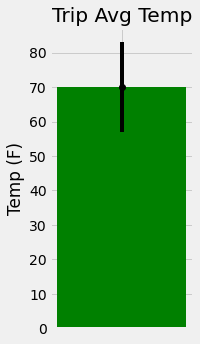

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

maxt = temps[0]['max(temp)']
mint = temps[0]['min(temp)']
y_error = maxt - mint
xaxis = ['']
yaxis = temps[0]['avg(temp)']
plt.figure(figsize=(3, 5))
plt.bar(xaxis, yaxis, color='g')
plt.errorbar(xaxis, yaxis, 
             yerr = y_error, 
             fmt ='o', color = 'black')
plt.title("Trip Avg Temp")
plt.ylabel('Temp (F)')
plt.tight_layout()
plt.show()

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
start_date = '2017-01-06'
end_date = '2017-01-20'
df = pd.read_sql(f""" 
    SELECT date, station, sum(prcp) as percipitation, latitude, longitude, elevation
    FROM station_measurements
    WHERE date BETWEEN DATE('{start_date}', '-1 year') and DATE('{end_date}', '-1 year')
    GROUP BY station
    ORDER BY percipitation DESC;

""", engine)
df

,date,station,percipitation,latitude,longitude,elevation
0,2016-01-06,USC00516128,2.82,21.33310,-157.80250,152.4
1,2016-01-06,USC00519281,0.86,21.45167,-157.84889,32.9
2,2016-01-06,USC00514830,0.64,21.52130,-157.83740,7.0
3,2016-01-06,USC00513117,0.46,21.42340,-157.80150,14.6
4,2016-01-06,USC00519397,0.24,21.27160,-157.81680,3.0
5,2016-01-06,USC00519523,0.00,21.33556,-157.71139,19.5
6,2016-01-20,USC00517948,0.00,21.39340,-157.97510,11.9


In [21]:
    df = pd.read_sql(f""" 
        SELECT *
        FROM station_measurements
        

    """, engine)
    df

,station,name,latitude,longitude,elevation,date,day,month,prcp,temp
0,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-01,01,01,0.08,65.0
1,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-02,02,01,0.00,63.0
2,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-03,03,01,0.00,74.0
3,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-04,04,01,0.00,76.0
4,USC00519397,"WAIKIKI 717.2, HI US",21.2716,-157.8168,3.0,2010-01-06,06,01,NaN,73.0
...,...,...,...,...,...,...,...,...,...,...
19545,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-19,19,08,0.09,71.0
19546,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-20,20,08,NaN,78.0
19547,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-21,21,08,0.56,76.0
19548,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.3331,-157.8025,152.4,2017-08-22,22,08,0.50,76.0


In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A DataFrame containing the daily normals, tmin, tavg, and tmax
    
    """
    sql = f""" 
        SELECT month || '-' || day as mo_day, min(temp) as tmin, max(temp) as tmax, avg(temp) as tavg
        FROM station_measurements
        WHERE month || '-' || day  = '{date}'
        ;

    """
    df = pd.read_sql(sql, engine)
    #print(sql)
    return df.to_dict(orient='records')[0]
    
daily_normals("01-01")

{'mo_day': '01-01', 'tmin': 62.0, 'tmax': 77.0, 'tavg': 69.15384615384616}

In [23]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
# Set the start and end date of the trip
# Use the start and end date to create a range of dates
# Stip off the year and save a list of %m-%d strings
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [ ]
dates = ["01-01-2020", "01-02-2020", "01-03-2020", "01-04-2020", "01-05-2020"]

for date in dates:
    md = date[:5]
    normals.append(daily_normals(md))
print(normals)


[{'mo_day': '01-01', 'tmin': 62.0, 'tmax': 77.0, 'tavg': 69.15384615384616}, {'mo_day': '01-02', 'tmin': 60.0, 'tmax': 77.0, 'tavg': 69.39622641509433}, {'mo_day': '01-03', 'tmin': 62.0, 'tmax': 77.0, 'tavg': 68.9090909090909}, {'mo_day': '01-04', 'tmin': 58.0, 'tmax': 76.0, 'tavg': 70.0}, {'mo_day': '01-05', 'tmin': 56.0, 'tmax': 76.0, 'tavg': 67.96428571428571}]


In [24]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals)
df['date'] = dates
df.set_index('date', inplace=True)
df.drop(columns='mo_day', inplace=True)
df

,tmin,tmax,tavg
date,,,
01-01-2020,62.0,77.0,69.153846
01-02-2020,60.0,77.0,69.396226
01-03-2020,62.0,77.0,68.909091
01-04-2020,58.0,76.0,70.000000
01-05-2020,56.0,76.0,67.964286


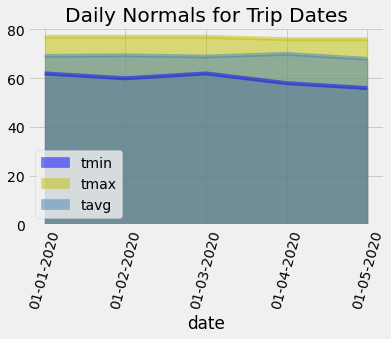

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot.area(stacked=False, x_compat=True, color=('blue','y','steelblue'), title='Daily Normals for Trip Dates')
plt.tight_layout()
plt.xticks(rotation=75)
#plt.savefig('Images/tripdailynormals.png')
plt.show()